In [1]:
import tensorflow as tf

2024-01-07 00:23:25.897174: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 00:23:26.043323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 00:23:26.043407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 00:23:26.047080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 00:23:26.131240: I tensorflow/core/platform/cpu_feature_guar

In [2]:
!pip install pandas
!pip install numpy
!pip install yfinance
!pip install matplotlib
!pip install statsmodels
!pip install scikit-learn
!pip install seaborn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
np.random.seed(69)
import seaborn as sns

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
df = yf.download("INFY.NS")[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

df["returns t-1"] = df[["returns"]].shift(1)

df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

df = df.dropna()

split = int(0.80*len(df))

X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)



from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

[*********************100%%**********************]  1 of 1 completed


In [17]:
np.random.seed(13)
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 1


classifier = Sequential()

for _ in range(nb_hidden_layer):
    classifier.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


classifier.add(Dense(1, activation="sigmoid"))

classifier.compile(loss="binary_crossentropy", optimizer="adam")

classifier.fit(X_train_scaled, y_train_cla, epochs=13, batch_size=150, verbose=1)

Epoch 1/13
38/38 [==============================] - 1s 2ms/step - loss: 0.6987
Epoch 2/13
38/38 [==============================] - 0s 2ms/step - loss: 0.6949
Epoch 3/13
38/38 [==============================] - 0s 3ms/step - loss: 0.6937
Epoch 4/13
38/38 [==============================] - 0s 3ms/step - loss: 0.6930
Epoch 5/13
38/38 [==============================] - 0s 3ms/step - loss: 0.6923
Epoch 6/13
38/38 [==============================] - 0s 3ms/step - loss: 0.6921
Epoch 7/13
38/38 [==============================] - 0s 4ms/step - loss: 0.6922
Epoch 8/13
38/38 [==============================] - 0s 3ms/step - loss: 0.6917
Epoch 9/13
38/38 [==============================] - 0s 2ms/step - loss: 0.6915
Epoch 10/13
38/38 [==============================] - 0s 3ms/step - loss: 0.6913
Epoch 11/13
38/38 [==============================] - 0s 2ms/step - loss: 0.6911
Epoch 12/13
38/38 [==============================] - 0s 3ms/step - loss: 0.6912
Epoch 13/13
38/38 [==============================

In [5]:
classifier.save("INFY.h5")

NameError: name 'classifier' is not defined

In [6]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
def backtest_tpsl_portfolio(dfc, ben="^NSEI", timeframe=252):

    """
    -----------------------------------------------------------------------------
    | Output: Backtest                                                          |
    -----------------------------------------------------------------------------
    | Inputs: - database (type dataframe pandas): data of the asset          |
    |         - ben (type string): Name of the benchmark                        |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """
    # COMPUTE TRADE LIFETIME
    sum_dates = dfc["duration"]
    seconds = np.round(np.mean(list(sum_dates.loc[sum_dates!=0])).total_seconds())
    minutes = seconds//60
    minutes_left = int(minutes%60)
    hours = int(minutes//60)

    # CREATE DAILY RETURNS
    portfolio = dfc["returns"]
    if portfolio.index.name != "Time":
        portfolio.index.name = "Time"


    portfolio = portfolio.reset_index(drop=False)
    portfolio.groupby(pd.Grouper(key='Time',freq='d')).sum()
    portfolio = portfolio.set_index("Time")

    ######################### COMPUTE THE BETA ##################################
    # Importation of benchmark
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

    # Concat the asset and the benchmark
    join = pd.concat((portfolio[["returns"]], benchmark), axis=1).dropna()

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    beta = cov/var

    ######################### COMPUTE THE ALPHA #################################
    # Mean of returns for the asset
    mean_stock_return = join.iloc[:,0].mean()*timeframe

    # Mean of returns for the market
    mean_market_return = join.iloc[:,1].mean()*timeframe

    # Alpha
    alpha = mean_stock_return - beta*mean_market_return

    ######################### COMPUTE THE SHARPE ################################
    mean = portfolio.mean() * np.sqrt(timeframe)
    std = portfolio.std()
    Sharpe = (mean/std)[0]


    ######################### COMPUTE THE SORTINO ###############################
    downward = portfolio[portfolio<0]* np.sqrt(timeframe)
    std_downward = downward.std()
    Sortino = (mean/std_downward)[0]


    ######################### COMPUTE THE DRAWDOWN ###############################
    # Compute the cumulative product returns
    coef_rets = (portfolio+1).cumprod()
    cum_rets = coef_rets-1

    # Compute the running max
    running_max = np.maximum.accumulate(coef_rets.dropna())
    #running_max[running_max < 1] = 1

    # Compute the drawdown
    drawdown = ((coef_rets/running_max) - 1)
    min_drawdon = (-drawdown.min())[0]

    ######################### COMPUTE THE VaR ##################################
    theta = 0.01
    # Number of simulations
    n = 100000

    # Find the values for theta% error threshold
    t = int(n*theta)

    # Create a vector with n simulations of the normal law
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)),columns = ["Simulations"])

    # Orderer the values and find the theta% value
    VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]


    ######################### COMPUTE THE cVaR #################################
    cVaR = -vec.sort_values(by="Simulations").iloc[0:t,:].mean().values[0]

    ######################### TIME UNDERWATER ##################################
    tuw = len(drawdown[drawdown["returns"]<0]) / len(drawdown)

    ######################### PLOT THE RESULTS #################################
    print(f"""
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)} %\t \
    AVERAGE TRADE LIFETIME: {hours}H {minutes_left}min
    -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)} %\t cVaR: {np.round(cVaR*100, 2)} % \t \
    TUW: {np.round(tuw*100,2)}%  \t drawdown: {np.round(min_drawdon*100, 2)} %
    -----------------------------------------------------------------------------""")

    plt.figure(figsize=(15,8))
    plt.plot(cum_rets*100, color="#035593", linewidth=3)
    plt.plot(join.iloc[:,1].cumsum()*100, color="#068C72", linewidth=3)
    plt.title("CUMULTATIVE RETURN", size=15)
    plt.ylabel("Cumulative return %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    # plt.title(["Strategy", "Benchmark"])
    plt.show()

    plt.figure(figsize=(15,8))
    plt.fill_between(drawdown.index, drawdown.iloc[:,0]*100, 0, color="#CE5151")
    plt.plot(drawdown.index,drawdown.iloc[:,0]*100, color="#930303", linewidth=3)


    plt.title("DRAWDOWN", size=15)
    plt.ylabel("Drawdown %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.show()




def backtest_static_portfolio(weights, database, ben="^NSEI", timeframe=252, CR=False):
    """
    -----------------------------------------------------------------------------
    | Output: Beta CAPM metric                                                  |
    -----------------------------------------------------------------------------
    | Inputs: - weights (type 1d array numpy): weights of the portfolio         |
    |         - database (type dataframe pandas): Returns of the asset          |
    |         - ben (type string): Name of the benchmark                        |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """
    import pandas as pd
    import yfinance as yf
    import numpy as np
    from scipy.optimize import minimize
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')


    # Compute the portfolio
    portfolio = np.multiply(database,np.transpose(weights))
    portfolio = portfolio.sum(axis=1)
    columns = database.columns
    columns = [col for col in columns]

    ######################### COMPUTE THE BETA ##################################
    # Importation of benchmark
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

    # Concat the asset and the benchmark
    join = pd.concat((portfolio, benchmark), axis=1).dropna()

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    beta = cov/var


    ######################### COMPUTE THE ALPHA #################################
    # Mean of returns for the asset
    mean_stock_return = join.iloc[:,0].mean()*timeframe

    # Mean of returns for the market
    mean_market_return = join.iloc[:,1].mean()*timeframe

    # Alpha
    alpha = mean_stock_return - beta*mean_market_return


    ######################### COMPUTE THE SHARPE ################################
    mean = portfolio.mean() * timeframe
    std = portfolio.std() * np.sqrt(timeframe)
    Sharpe = mean/std


    ######################### COMPUTE THE SORTINO ###############################
    downward = portfolio[portfolio<0]
    std_downward = downward.std() * np.sqrt(timeframe)
    Sortino = mean/std_downward


    ######################### COMPUTE THE DRAWDOWN ###############################
    # Compute the cumulative product returns
    cum_rets = (portfolio+1).cumprod()

    # Compute the running max
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1

    # Compute the drawdown
    drawdown = ((cum_rets)/running_max - 1)
    min_drawdon = -drawdown.min()


    ######################### COMPUTE THE VaR ##################################
    theta = 0.01
    # Number of simulations
    n = 100000

    # Find the values for theta% error threshold
    t = int(n*theta)

    # Create a vector with n simulations of the normal law
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)),
    columns = ["Simulations"])

    # Orderer the values and find the theta% value
    VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]


    ######################### COMPUTE THE cVaR #################################
    cVaR = -vec.sort_values(by="Simulations").iloc[0:t,:].mean().values[0]

    ######################### COMPUTE THE RC ###################################
    if CR:
        # Find the number of the asset in the portfolio
        l = len(weights)

        # Compute the risk contribution of each asset
        crs = []
        for i in range(l):
            # Importation of benchmark
            benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

            # Concat the asset and the benchmark
            join = pd.concat((database.iloc[:,i], benchmark), axis=1).dropna()

            # Covariance between the asset and the benchmark
            cov = np.cov(join, rowvar=False)[0][1]

            # Compute the variance of the benchmark
            var = np.cov(join, rowvar=False)[1][1]
            beta_s = cov/var
            cr = beta_s * weights[i]
            crs.append(cr)
            crs_ = crs/np.sum(crs) # Normalizing by the sum of the risk contribution

    ######################### PLOT THE RESULTS #################################
    print(f"""
    -----------------------------------------------------------------------------
    Portfolio: {columns}
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)} %\t \
    Sharpe: {np.round(Sharpe, 3)} \t Sortino: {np.round(Sortino, 3)}
    -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)} %\t cVaR: {np.round(cVaR*100, 2)} % \t \
    VaR/cVaR: {np.round(cVaR/VaR, 3)} \t drawdown: {np.round(min_drawdon*100, 2)} %
    -----------------------------------------------------------------------------
    """)

    plt.figure(figsize=(15,8))
    plt.plot(join.iloc[:,0].cumsum()*100, color="#035593", linewidth=3)
    plt.plot(join.iloc[:,1].cumsum()*100, color="#068C72", linewidth=3)
    plt.title("CUMULTATIVE RETURN", size=15)
    plt.ylabel("Cumulative return %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    # plt.legend(["Strategy", "Benchmark"])
    plt.savefig(f'Cum.svg', format='svg', dpi=1200)
    plt.show()

    plt.figure(figsize=(15,8))
    plt.fill_between(drawdown.index, drawdown*100, 0, color="#CE5151")
    plt.plot(drawdown.index,drawdown*100, color="#930303", linewidth=1.5)
    plt.title("DRAWDOWN", size=15)
    plt.ylabel("Drawdown %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.savefig(f'drawdown.svg', format='svg', dpi=1200)
    plt.show()



    if CR:
        plt.figure(figsize=(15,8))
        plt.scatter(columns, crs_, linewidth=3, color = "#B96553")
        plt.axhline(0, color="#53A7B9")
        plt.grid(axis="x")
        plt.title("RISK CONTRIBUTION PORTFOLIO", size=15)
        plt.xlabel("Assets")
        plt.ylabel("Risk contribution")
        plt.xticks(size=15,fontweight="bold")
        plt.yticks(size=15,fontweight="bold")
        plt.savefig(f'CR.svg', format='svg', dpi=1200)
        plt.show()
        plt.show()



OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [25]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl


def backtest_dynamic_portfolio(dfc, ben="^NSEI", timeframe=252):
  """
  -----------------------------------------------------------------------------
  | Output: Beta CAPM metric                                                  |
  -----------------------------------------------------------------------------
  | Inputs: - weights (type 1d array numpy): weights of the portfolio         |
  |         - database (type dataframe pandas): Returns of the asset          |
  |         - ben (type string): Name of the benchmark                        |
  |         - timeframe (type int): annualization factor                      |
  -----------------------------------------------------------------------------
  """
  import pandas as pd
  import yfinance as yf
  import numpy as np
  from scipy.optimize import minimize
  import matplotlib.pyplot as plt
  plt.style.use('seaborn')
  import matplotlib as mpl
  import matplotlib.pyplot as plt

  from matplotlib import cycler


  font = {'weight' : 'bold', "size":"300"}
  plt.rc('font', **font)

  # Maybe from series to dataframe
  if str(type(dfc)) == "<class 'pandas.core.series.Series'>":
    dfc = pd.DataFrame(dfc)

  # find the returns
  if len(dfc.columns)==1:
    dfc.columns=["returns"]


  # CREATE DAILY RETURNS
  portfolio = dfc["returns"]
  if portfolio.index.name != "Time":
      portfolio.index.name = "Time"


  portfolio = portfolio.reset_index(drop=False)
  portfolio.groupby(pd.Grouper(key='Time',freq='d')).sum()
  portfolio = portfolio.set_index("Time")
  ######################### COMPUTE THE BETA ##################################
  # Importation of benchmark
  benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

  # Concat the asset and the benchmark
  join = pd.concat((portfolio, benchmark), axis=1).dropna()

  # Covariance between the asset and the benchmark
  cov = np.cov(join, rowvar=False)[0][1]

  # Compute the variance of the benchmark
  var = np.cov(join, rowvar=False)[1][1]

  beta = cov/var


  ######################### COMPUTE THE ALPHA #################################
  # Mean of returns for the asset
  mean_stock_return = join.iloc[:,0].mean()*timeframe

  # Mean of returns for the market
  mean_market_return = join.iloc[:,1].mean()*timeframe

  # Alpha
  alpha = mean_stock_return - beta*mean_market_return


  ######################### COMPUTE THE SHARPE ################################
  mean = portfolio.mean() * np.sqrt(timeframe)
  std = portfolio.std()
  Sharpe = (mean/std)[0]


  ######################### COMPUTE THE SORTINO ###############################
  downward = portfolio[portfolio<0]* np.sqrt(timeframe)
  std_downward = downward.std()
  Sortino = (mean/std_downward)[0]


  ######################### COMPUTE THE DRAWDOWN ###############################
  # Compute the cumulative product returns
  coef_rets = (portfolio+1).cumprod()
  cum_rets = coef_rets-1

  # Compute the running max
  running_max = np.maximum.accumulate(coef_rets.dropna())
  #running_max[running_max < 1] = 1

  # Compute the drawdown
  drawdown = ((coef_rets/running_max) - 1)
  min_drawdon = (-drawdown.min())[0]


  ######################### COMPUTE THE VaR ##################################
  theta = 0.01
  # Number of simulations
  n = 100000

  # Find the values for theta% error threshold
  t = int(n*theta)

  # Create a vector with n simulations of the normal law
  vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)),columns = ["Simulations"])

  # Orderer the values and find the theta% value
  VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]


  ######################### COMPUTE THE cVaR #################################
  cVaR = -vec.sort_values(by="Simulations").iloc[0:t,:].mean().values[0]

  ######################### TIME UNDERWATER ##################################
  tuw = len(drawdown[drawdown<0]) / len(drawdown)

  ######################### PLOT THE RESULTS #################################
  print(f"""
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)} %\t \
    Sharpe: {np.round(Sharpe, 3)} \t Sortino: {np.round(Sortino, 3)}
  -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)} %\t cVaR: {np.round(cVaR*100, 2)} % \t \
    VaR/cVaR: {np.round(cVaR/VaR, 3)} \t drawdown: {np.round(min_drawdon*100, 2)} %
  -----------------------------------------------------------------------------""")


  plt.figure(figsize=(15,8))
  plt.plot(join.iloc[:,0].cumsum()*100, color="#035593", linewidth=3)
  plt.plot(join.iloc[:,1].cumsum()*100, color="#068C72", linewidth=3)
  plt.title("CUMULTATIVE RETURN", size=15)
  plt.ylabel("Cumulative return %", size=15)
  plt.xticks(size=15,fontweight="bold")
  # plt.yticks(size=15,fontweight="bold")
  plt.yticks(np.arange(0, 200, 10), size=15, fontweight="bold")

  # plt.legend(["Strategy", "Benchmark"])
  plt.show()

  plt.figure(figsize=(15,8))
  plt.fill_between(drawdown.index, drawdown.iloc[:,0]*100, 0, color="#CE5151")
  plt.plot(drawdown.index,drawdown.iloc[:,0]*100, color="#930303", linewidth=3)
  plt.title("DRAWDOWN", size=15)
  plt.ylabel("Drawdown %", size=15)
  plt.xticks(size=15,fontweight="bold")
  plt.yticks(size=15,fontweight="bold")
  plt.show()


219/219 [==============================] - 0s 1ms/step
[*********************100%%**********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.694 	 Alpha: 8.41 %	     Sharpe: 0.953 	 Sortino: 0.083
  -----------------------------------------------------------------------------
    VaR: 3.5 %	 cVaR: 4.31 % 	     VaR/cVaR: 1.232 	 drawdown: 83.0 %
  -----------------------------------------------------------------------------


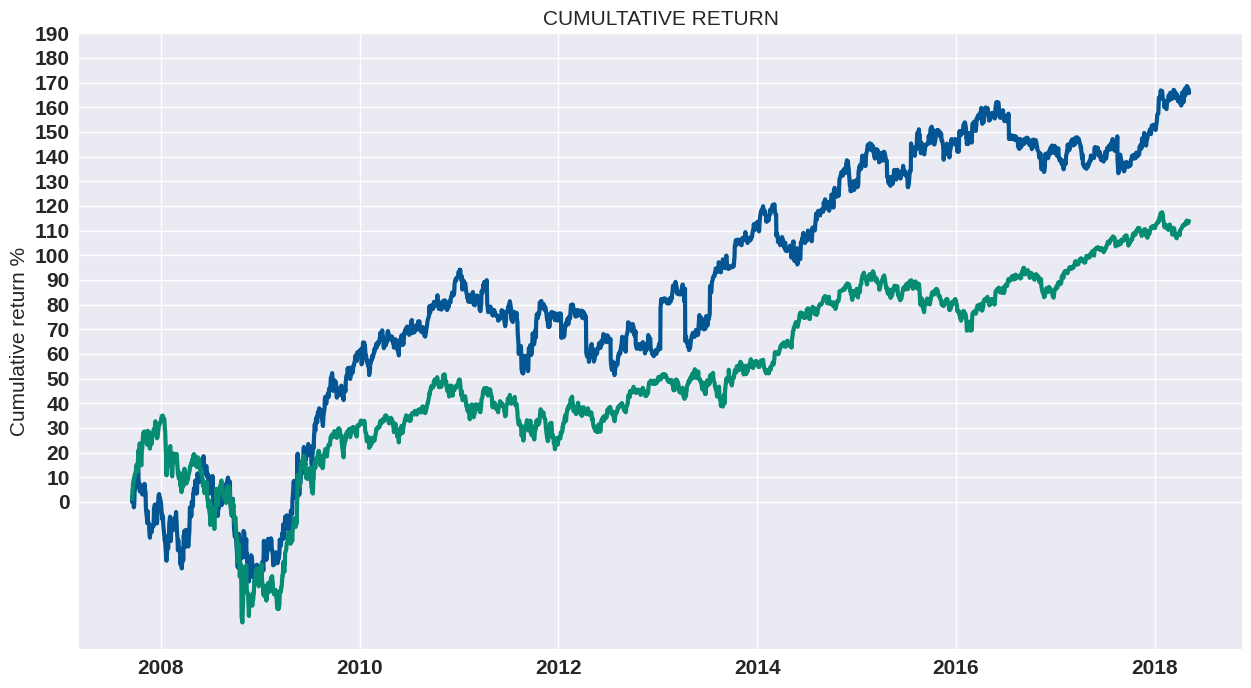

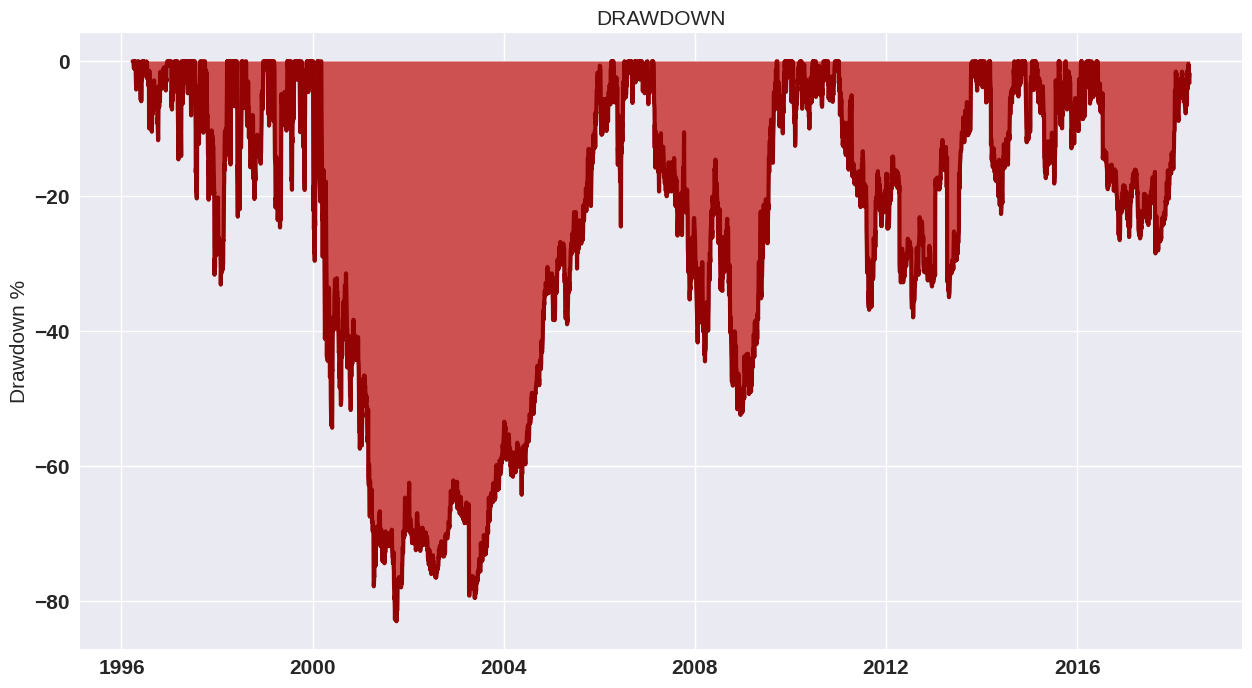

In [26]:
# Create predictions for the whole dataset
df["prediction"] = classifier.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"] == 0, -1,1)
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[:split])

In [27]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def backtest_dynamic_portfolio(dfc, ben="^NSEI", timeframe=252):
    """
    -----------------------------------------------------------------------------
    | Output: Beta CAPM metric                                                  |
    -----------------------------------------------------------------------------
    | Inputs: - weights (type 1d array numpy): weights of the portfolio         |
    |         - database (type dataframe pandas): Returns of the asset          |
    |         - ben (type string): Name of the benchmark                        |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """
    # Convert the index to a datetime index if it's not already
    if not pd.api.types.is_datetime64_any_dtype(dfc.index):
        dfc.index = pd.to_datetime(dfc.index)

    import yfinance as yf
    import numpy as np
    import seaborn as sns

    font = {'weight': 'bold', 'size': '36'}
    plt.rc('font', **font)

    # Maybe from series to dataframe
    if str(type(dfc)) == "<class 'pandas.core.series.Series'>":
        dfc = pd.DataFrame(dfc)

    # find the returns
    if len(dfc.columns) == 1:
        dfc.columns = ["returns"]

    # CREATE DAILY RETURNS
    portfolio = dfc["returns"]
    if portfolio.index.name != "Time":
        portfolio.index.name = "Time"

    portfolio = portfolio.reset_index(drop=False)
    portfolio.groupby(pd.Grouper(key='Time', freq='d')).sum()
    portfolio = portfolio.set_index("Time")

    ######################### COMPUTE THE BETA ##################################
    # Importation of benchmark
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

    # Concat the asset and the benchmark
    join = pd.concat((portfolio, benchmark), axis=1).dropna()

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    beta = cov / var

    ######################### COMPUTE THE ALPHA #################################
    # Mean of returns for the asset
    mean_stock_return = join.iloc[:, 0].mean() * timeframe

    # Mean of returns for the market
    mean_market_return = join.iloc[:, 1].mean() * timeframe

    # Alpha
    alpha = mean_stock_return - beta * mean_market_return

    ######################### COMPUTE THE SHARPE ################################
    mean = portfolio.mean() * np.sqrt(timeframe)
    std = portfolio.std()
    Sharpe = (mean / std)[0]

    ######################### COMPUTE THE SORTINO ###############################
    downward = portfolio[portfolio < 0] * np.sqrt(timeframe)
    std_downward = downward.std()
    Sortino = (mean / std_downward)[0]

    ######################### COMPUTE THE DRAWDOWN ###############################
    # Compute the cumulative product returns
    coef_rets = (portfolio + 1).cumprod()
    cum_rets = coef_rets - 1

    # Compute the running max
    running_max = np.maximum.accumulate(coef_rets.dropna())

    # Compute the drawdown
    drawdown = ((coef_rets / running_max) - 1)
    min_drawdown = (-drawdown.min())[0]

    ######################### COMPUTE THE VaR ##################################
    theta = 0.01
    # Number of simulations
    n = 100000

    # Find the values for theta% error threshold
    t = int(n * theta)

    # Create a vector with n simulations of the normal law
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)), columns=["Simulations"])

    # Order the values and find the theta% value
    VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]

    ######################### COMPUTE THE cVaR #################################
    cVaR = -vec.sort_values(by="Simulations").iloc[0:t, :].mean().values[0]

    ######################### TIME UNDERWATER ##################################
    tuw = len(drawdown[drawdown < 0]) / len(drawdown)

    dfc['Year'] = dfc.index.year
    dfc['Month'] = dfc.index.month

    # Pivot the DataFrame to create a matrix with months as rows, years as columns, and returns as values
    returns_matrix = dfc.pivot_table(values='returns', index='Month', columns='Year', aggfunc='mean')

    # Create a heatmap using seaborn
    plt.figure(figsize=(120, 80))
    sns.heatmap(returns_matrix, cmap='RdYlGn', annot=True, fmt=".2%", cbar_kws={'format': '%.2f%%'}, annot_kws={'size': 36})
    plt.title('Monthly Returns Across Years', size=4)
    plt.xticks(size=36, fontweight="bold")
    plt.yticks(size=36, fontweight="bold")
    plt.xlabel('Year', size=36)
    plt.ylabel('Month', size=36)
    plt.show()

    yearly_returns = dfc.groupby('Year')['returns'].sum()
    plt.figure(figsize=(12, 6))
    yearly_returns.plot(kind='bar', color='skyblue')
    plt.title('Yearly Returns', size=15)
    plt.xlabel('Year', size=13)
    plt.ylabel('Returns', size=13)
    plt.xticks(rotation=45, size=13, fontweight="bold")
    plt.yticks(size=13, fontweight="bold")
    plt.show()

219/219 [==============================] - 0s 2ms/step
[*********************100%%**********************]  1 of 1 completed


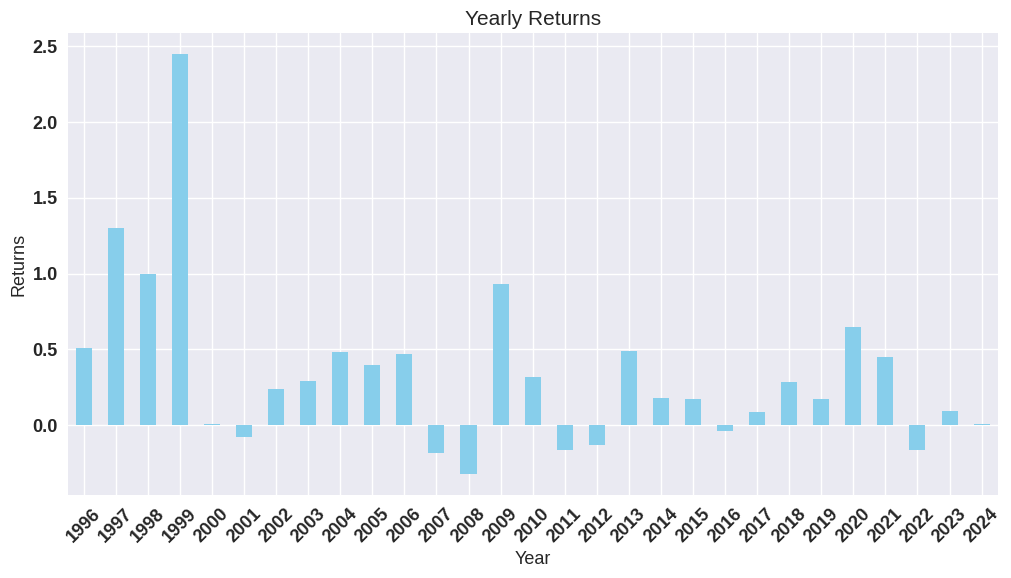

In [31]:
# Create predictions for the whole dataset
df["prediction"] = classifier.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"] == 0, -1,1)
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[:])